In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader,random_split

# Get cpu, gpu or mps device for training.
# This ensures the fastest training and prediction for PyTorch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


number of points: 400
categories: [0 1]


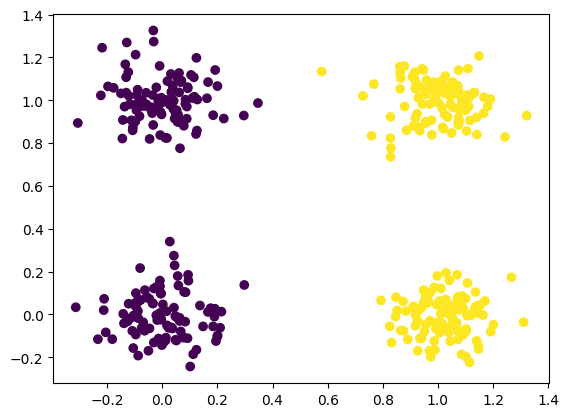

In [4]:
## Non linearly separable data : the infamous Xor problem
N = 10**2
blob_X = np.concatenate( [np.random.randn(N,2)*0.1 + np.array([0,0]),
                     np.random.randn(N,2)*0.1 + np.array([0,1]),
                     np.random.randn(N,2)*0.1 + np.array([1,1]),
                     np.random.randn(N,2)*0.1 + np.array([1,0])
                    ])

blob_y = np.array( [0]*N + [0]*N + [1]*N + [1]*N )

## shuffling, for good measure:
indexes = np.arange(blob_y.shape[0])
rng = np.random.default_rng()
rng.shuffle(indexes)

blob_X = blob_X[indexes,:]
blob_y = blob_y[indexes]


print('number of points:',len(blob_y))
print('categories:',np.unique(blob_y))
plt.scatter( blob_X[:,0],blob_X[:,1],c=blob_y )

In [5]:
# transform to torch tensor
tensor_X = torch.Tensor(blob_X) 
tensor_y = torch.Tensor(blob_y)

# create your dataset
full_dataset = TensorDataset(tensor_X,tensor_y) 

# split between train and validation datasets
train_dataset, valid_dataset = random_split(full_dataset , [320,80] )

In [6]:
display(train_dataset)
display(len( train_dataset ) , len( valid_dataset ))
display(train_dataset[0])

320

80

(tensor([0.0662, 1.0847]), tensor(0.))

In [12]:
## creating a dataloader
##   -> wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling 
##           and multiprocess data loading. 
##  not 100% needed here, but better to adopt best practices early on

train_dataloader = DataLoader(train_dataset , batch_size = 32 , shuffle=True ) 
valid_dataloader = DataLoader(valid_dataset , batch_size = 32 , shuffle=True) 

display(train_dataloader)
display(len( train_dataloader ) , train_dataloader.batch_size)
display(next( iter( train_dataloader ) ))

10

32

[tensor([[ 0.0628, -0.0310],
         [-0.2228,  1.0229],
         [ 0.9570, -0.0475],
         [ 0.8649,  1.1036],
         [ 0.1238,  1.1980],
         [ 0.0229, -0.0627],
         [-0.1121,  0.9064],
         [ 0.9113,  0.8798],
         [ 0.9214,  1.0763],
         [ 1.1705,  0.0625],
         [ 0.0421,  0.2743],
         [ 0.9486,  0.0569],
         [-0.1313,  1.1075],
         [ 0.0366, -0.0660],
         [ 0.1096,  1.0102],
         [ 0.0783, -0.1089],
         [ 0.8278,  0.8232],
         [-0.0643, -0.0765],
         [ 1.0874,  0.9966],
         [ 0.0114, -0.1222],
         [ 0.0311,  1.1228],
         [ 1.0998,  0.9534],
         [ 0.0327,  1.0384],
         [ 0.9444,  0.9823],
         [-0.0097,  1.1605],
         [ 1.0697,  0.1849],
         [ 1.1374,  0.0367],
         [-0.0827,  0.9256],
         [ 1.1112,  0.9713],
         [ 1.3111, -0.0362],
         [ 1.1811,  0.9717],
         [ 0.9175,  0.9159]]),
 tensor([0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [9]:
# Logistic regression as a Pytorch module
class LR_neuralNet(torch.nn.Module):
    
    def __init__(self , input_dim = 2):
        super().__init__()
        self.layers = nn.Sequential( nn.Linear(input_dim, 1),          # Linear layer
                                     nn.Sigmoid()  # Non-linear activation
                                   )
        
        
    def forward(self, x):  # Forward pass
        proba = self.layers(x) 
        ## NB: here, the input  of the Sigmoid layer are logits
        ##           the output of the Sigmoid layer are probas
        return proba


model = LR_neuralNet( input_dim = 2 ).to(device)

print(model)
print(pms.summary(model , torch.zeros(1,2).to(device), show_input=True) )

LR_neuralNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1              [1, 2]               3               3
         Sigmoid-2              [1, 1]               0               0
Total params: 3
Trainable params: 3
Non-trainable params: 0
-----------------------------------------------------------------------


In [ ]:
model.eval()

# Example with one data point
x, y = valid_dataset[0]

with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
    x = x.to(device)
    pred = model(x)
    predicted, actual = pred[0], y
    print(f'Predicted proba: "{predicted}", Actual: "{actual}"')
    
pred_cpu = pred.to("cpu")
loss = nn.BCELoss()(pred, y.unsqueeze(0).to(device))

display(((pred_cpu>0.5).numpy() == y.numpy()).sum())
display((pred>0.5).float())
display((pred>0.5).float() == y.unsqueeze(0).to(device))
display("loss: ", loss)

## in practice this happens at the scale of a batch :
x, y = next(iter(valid_dataloader))

with torch.no_grad(): 
    x = x.to(device)
    y = y.to(device)
    pred = model(x)
    print( f'loss: {nn.BCELoss()(pred, y.unsqueeze(1)).item():>7f}' )
    print( f"number of correct predictions: {((pred.to('cpu')>0.5).numpy() == y.to('cpu').numpy()).sum()}")

Predicted proba: "0.5994653701782227", Actual: "0.0"


0

tensor([1.])

tensor([False])

'loss: '

tensor(0.9150)

loss: 0.615434
number of correct predictions: 512


In [14]:
def train(dataloader, model, loss_fn, optimizer , echo = True):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X, y) in enumerate(dataloader): # for each batch
        X, y = X.to(device), y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred.squeeze(), y)      # loss function from these prediction
        
        # Backpropagation
        loss.backward()              # backward propagation 
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients

        if echo:
            current =  (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    # return the last batch loss:
    return loss.item()

def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss, correct = 0, 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y.unsqueeze(1)).item()  ## accumulating the loss function over the batches
            
            correct += ((pred>0.5).float() == y.unsqueeze(1)).float().sum().item() ## counting number of true predictions
            
    valid_loss /= num_batches
    correct /= size
    if echo:
        print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    ## return the average loss / batch
    return valid_loss


# Actual Training

In [15]:
%%time

# Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()
# Stochastic Gradient Decent Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) 

epochs = 5
train_losses = []
valid_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=True) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn) )
print("Done!")

Epoch 1
-------------------------------
loss: 0.619155  [   32/  320]
loss: 0.556582  [   64/  320]
loss: 0.584176  [   96/  320]
loss: 0.617577  [  128/  320]
loss: 0.573290  [  160/  320]
loss: 0.549388  [  192/  320]
loss: 0.589025  [  224/  320]
loss: 0.576615  [  256/  320]
loss: 0.582679  [  288/  320]
loss: 0.582106  [  320/  320]
Valid Error: 
 Accuracy: 72.5%, Avg loss: 0.574965 

Epoch 2
-------------------------------
loss: 0.534813  [   32/  320]
loss: 0.565148  [   64/  320]
loss: 0.541167  [   96/  320]
loss: 0.552997  [  128/  320]
loss: 0.542589  [  160/  320]
loss: 0.594865  [  192/  320]
loss: 0.523900  [  224/  320]
loss: 0.562386  [  256/  320]
loss: 0.515390  [  288/  320]
loss: 0.483114  [  320/  320]
Valid Error: 
 Accuracy: 73.8%, Avg loss: 0.534869 

Epoch 3
-------------------------------
loss: 0.526093  [   32/  320]
loss: 0.509636  [   64/  320]
loss: 0.496568  [   96/  320]
loss: 0.485170  [  128/  320]
loss: 0.486186  [  160/  320]
loss: 0.536662  [  192/ 

Valid Error: 
 Accuracy: 98.8%, Avg loss: 0.416062 



Text(0, 0.5, 'cross-entropy loss')

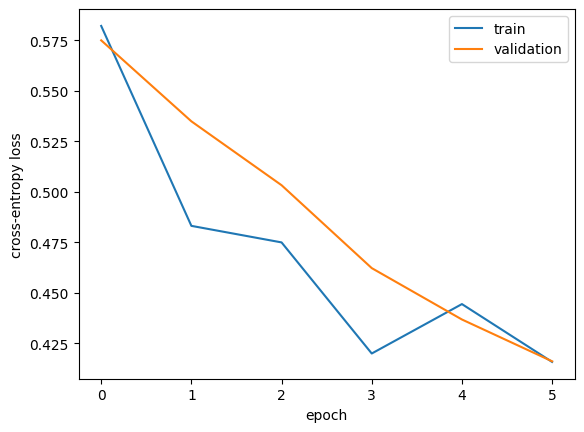

In [16]:
#from there we can continue training a bit
train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
valid_losses.append( valid(valid_dataloader, model, loss_fn) )
plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')


## Non-linearly seperable data

number of points: 400
categories: [0 1]


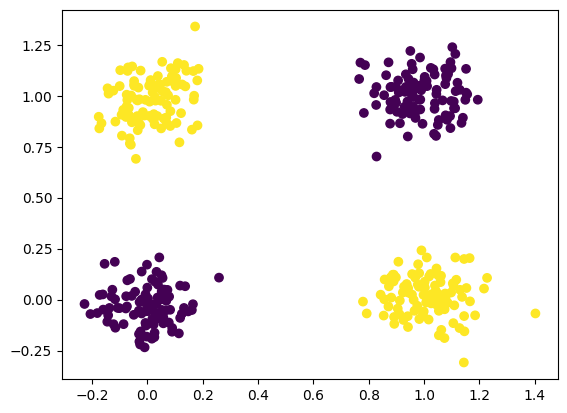

In [17]:
N = 10**2
xor_X = np.concatenate( [np.random.randn(N,2)*0.1 + np.array([0,0]),
                     np.random.randn(N,2)*0.1 + np.array([1,1]),
                     np.random.randn(N,2)*0.1 + np.array([1,0]),
                     np.random.randn(N,2)*0.1 + np.array([0,1])
                    ])

xor_y = np.array( [0]*N + [0]*N + [1]*N + [1]*N )

## shuffling, for good measure:
indexes = np.arange(xor_y.shape[0])
rng = np.random.default_rng()
rng.shuffle(indexes)

xor_X = xor_X[indexes,:]
xor_y = xor_y[indexes]


print('number of points:',len(xor_y))
print('categories:',np.unique(xor_y))
plt.scatter( xor_X[:,0],xor_X[:,1],c=xor_y )

In [18]:
#Preprocessing 

# transform to torch tensor
tensor_X = torch.Tensor(xor_X) 
tensor_y = torch.Tensor(xor_y)

# create your dataset
full_dataset = TensorDataset(tensor_X,tensor_y)

# split between train and validation datasets
train_dataset, valid_dataset = random_split(full_dataset , [320,80] )

## creating a dataloader
train_dataloader = DataLoader(train_dataset , batch_size = 32 ) 
valid_dataloader = DataLoader(valid_dataset , batch_size = 32 ) 

model = LR_neuralNet( input_dim = 2 ).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1) 

before training:
Valid Error: 
 Accuracy: 36.2%, Avg loss: 0.701734 

Done!
after training:
Valid Error: 
 Accuracy: 36.2%, Avg loss: 0.701734 

CPU times: total: 234 ms
Wall time: 623 ms


Text(0, 0.5, 'cross-entropy loss')

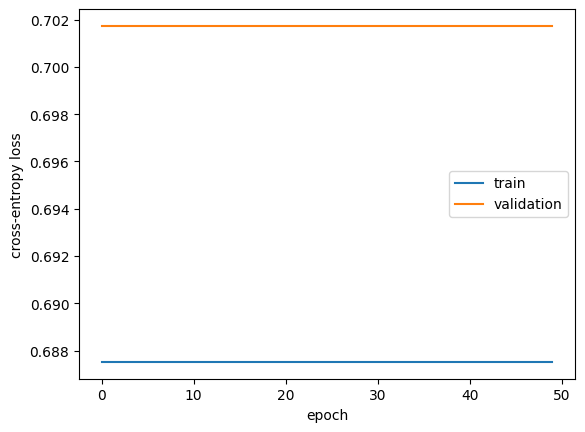

In [28]:
%%time

epochs = 50
train_losses = []
valid_losses = []

print("before training:")
valid(valid_dataloader, model, loss_fn , echo = True)

for t in range(epochs):
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = False) )
print("Done!")
print("after training:")
valid(valid_dataloader, model, loss_fn , echo = True)

plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')

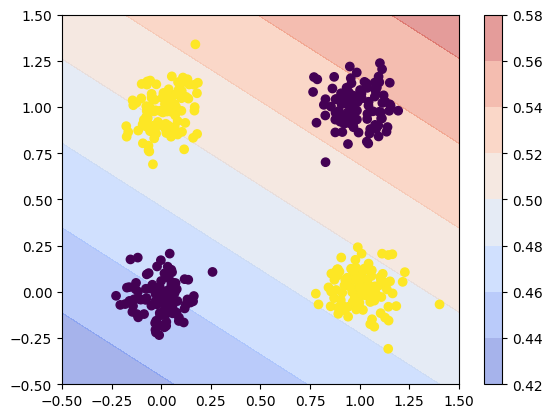

In [ ]:
fig,ax = plt.subplots()

xx, yy = np.meshgrid(np.linspace(-0.5,1.5,100),np.linspace(-0.5,1.5,100))

pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)).to("cpu").detach().numpy()
Z = pred.reshape(xx.shape)


CS = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
cbar = plt.colorbar(CS, ax=ax)

ax.scatter(xor_X[:,0],xor_X[:,1],c=xor_y)

In [ ]:
# More complicated model
class deepLR_neuralNet(torch.nn.Module):
    
    def __init__(self , input_dim = 2, hidden_dim = 3, dropout_rate=0.5):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_dim, 3),          # Linear layer
                                    nn.ReLU(),  # Non-linear activation
                                    nn.Dropout(dropout_rate), # Dropout regularization to prevent overfitting
                                    nn.Linear(3,1),
                                    nn.Sigmoid()
                                   )
        
        
    def forward(self, x):  # Forward pass
        proba = self.layers(x) 
        ## NB: here, the input  of the Sigmoid layer are logits
        ##           the output of the Sigmoid layer are probas
        return proba


model = deepLR_neuralNet( input_dim = 2 ).to(device)
print(model)


deepLR_neuralNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=3, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [51]:
#Preprocessing 

# transform to torch tensor
tensor_X = torch.Tensor(xor_X) 
tensor_y = torch.Tensor(xor_y)

# create your dataset
full_dataset = TensorDataset(tensor_X,tensor_y)

# split between train and validation datasets
train_dataset, valid_dataset = random_split(full_dataset , [320,80] )

## creating a dataloader
train_dataloader = DataLoader(train_dataset , batch_size = 32 ) 
valid_dataloader = DataLoader(valid_dataset , batch_size = 32 ) 

model = deepLR_neuralNet( input_dim = 2 ).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.9) 

before training:
Valid Error: 
 Accuracy: 61.3%, Avg loss: 0.712643 

Done!
after training:
Valid Error: 
 Accuracy: 75.0%, Avg loss: 0.431264 

CPU times: total: 422 ms
Wall time: 1.49 s


Text(0, 0.5, 'cross-entropy loss')

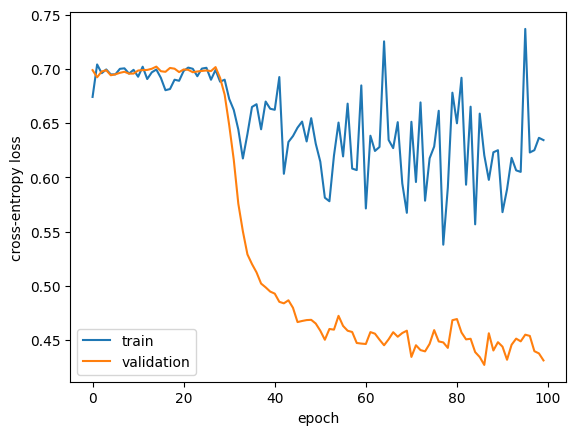

In [52]:
%%time

epochs = 100
train_losses = []
valid_losses = []

print("before training:")
valid(valid_dataloader, model, loss_fn , echo = True)

for t in range(epochs):
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = False) )
print("Done!")
print("after training:")
valid(valid_dataloader, model, loss_fn , echo = True)

plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')

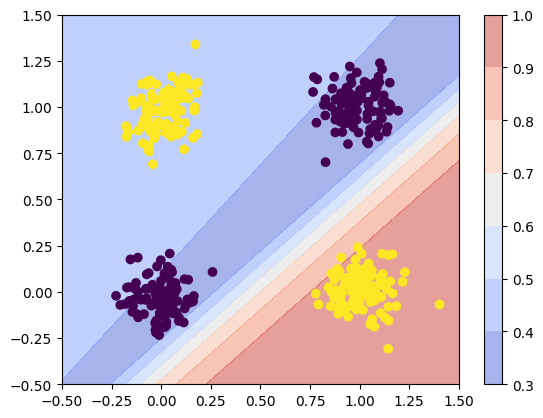

In [56]:
fig,ax = plt.subplots()

xx, yy = np.meshgrid(np.linspace(-0.5,1.5,100),np.linspace(-0.5,1.5,100))

pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)).detach().cpu().numpy()
Z = pred.reshape(xx.shape)


CS = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
cbar = plt.colorbar(CS, ax=ax)

ax.scatter(xor_X[:,0],xor_X[:,1],c=xor_y)

#We can have a look at the latent space represented in the hidden layer.
W_hidden=model.layers[0].weight.detach().cpu().numpy()
b_hidden=model.layers[0].bias.detach().cpu().numpy()

linear_representation = xor_X @ W_hidden.T + \
                            b_hidden
ReLU_representation = [[i[p] if i[p]>0 else 0 for i in linear_representation] for p in range(3)]


## Hyperparameter Tuning

In [64]:
from functools import partial
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Define your model with dropout
class deepLR_neuralNetWithDropout(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=3, dropout_rate=0.5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),          # Linear layer
            nn.ReLU(),                                # ReLU activation
            nn.Dropout(dropout_rate),                 # Dropout regularization
            nn.Linear(hidden_dim, 1),                  # Output layer
            nn.Sigmoid()                              # Sigmoid activation for binary classification
        )

    def forward(self, x):
        return self.layers(x)

# Define the training function
def train_LRdeep(trial, train_dataloader, valid_dataloader, device):
    # Hyperparameter tuning: using optuna's trial object
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)  # Log uniform distribution for lr
    momentum = trial.suggest_uniform('momentum', 0.5, 0.9)  # Uniform distribution for momentum
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)  # Uniform distribution for dropout rate
    hidden_dim = trial.suggest_int('hidden_dim', 3, 20)  # Integer distribution for hidden_dim

    model = deepLR_neuralNetWithDropout(input_dim=2, hidden_dim=hidden_dim, dropout_rate=dropout_rate).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    train_losses = []
    valid_losses = []
    epochs = 100
    
    for t in range(epochs):
        train_loss = train(train_dataloader, model, loss_fn, optimizer, echo=False)
        train_losses.append(train_loss)
        
        valid_loss = valid(valid_dataloader, model, loss_fn, echo=False)
        valid_losses.append(valid_loss)

    return valid_losses[-1]  # We want to minimize the validation loss

# Define the objective function for Optuna
def objective(trial):
    # Assume that train_dataloader and valid_dataloader are defined elsewhere in your code
    return train_LRdeep(trial, train_dataloader, valid_dataloader, device)

# Create the Optuna study and optimize it
study = optuna.create_study(direction="minimize")  # We're minimizing the validation loss
study.optimize(objective, n_trials=50)  # 50 trials to search for the best hyperparameters

# Get the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

[I 2025-05-04 17:09:16,389] A new study created in memory with name: no-name-f03a08fa-1b3d-4457-91ac-1b9caf609031
C:\Users\ethan\AppData\Local\Temp\ipykernel_28920\495790866.py:25: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\ethan\AppData\Local\Temp\ipykernel_28920\495790866.py:26: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\ethan\AppData\Local\Temp\ipykernel_28920\495790866.py:27: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2025-05-04 17:09:18,114] Trial 0 finished with value: 0.2796668807665507 and parameters: {'lr': 0

Best hyperparameters: {'lr': 0.08807247011430103, 'momentum': 0.8808669334180634, 'dropout_rate': 0.16850371041088247, 'hidden_dim': 20}


before training:
Valid Error: 
 Accuracy: 56.2%, Avg loss: 0.694895 

Done!
after training:
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.000763 

CPU times: total: 844 ms
Wall time: 1.92 s


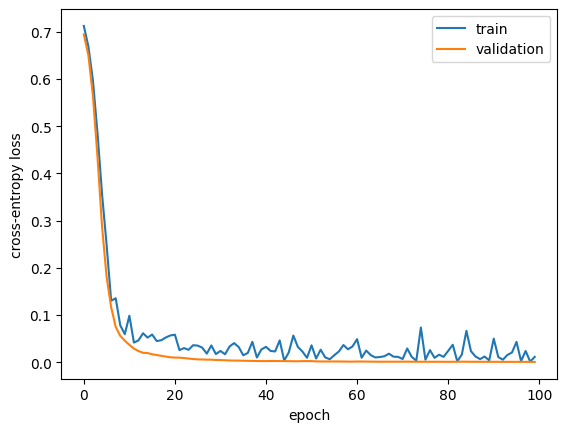

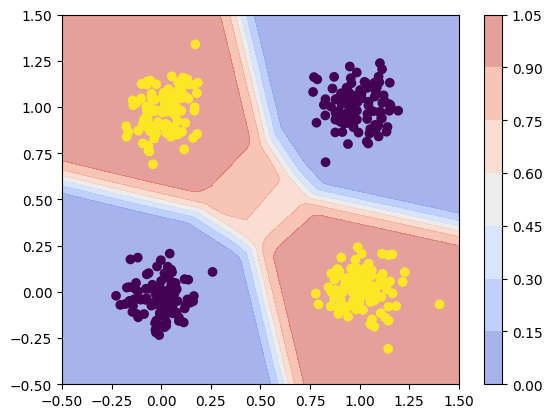

In [67]:
%%time

model = deepLR_neuralNetWithDropout(input_dim=2, hidden_dim=best_params['hidden_dim'], dropout_rate=best_params['dropout_rate'] ).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), best_params['lr'], best_params['momentum']) 

epochs = 100
train_losses = []
valid_losses = []

print("before training:")
valid(valid_dataloader, model, loss_fn , echo = True)

for t in range(epochs):
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = False) )
print("Done!")
print("after training:")
valid(valid_dataloader, model, loss_fn , echo = True)

plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')

fig,ax = plt.subplots()

xx, yy = np.meshgrid(np.linspace(-0.5,1.5,100),np.linspace(-0.5,1.5,100))

pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)).detach().cpu().numpy()
Z = pred.reshape(xx.shape)


CS = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
cbar = plt.colorbar(CS, ax=ax)

ax.scatter(xor_X[:,0],xor_X[:,1],c=xor_y)

#We can have a look at the latent space represented in the hidden layer.
W_hidden=model.layers[0].weight.detach().cpu().numpy()
b_hidden=model.layers[0].bias.detach().cpu().numpy()

linear_representation = xor_X @ W_hidden.T + \
                            b_hidden
ReLU_representation = [[i[p] if i[p]>0 else 0 for i in linear_representation] for p in range(3)]


## Handling initialization to ease optimization

before training:
Valid Error: 
 Accuracy: 43.8%, Avg loss: 0.714180 

Done!
after training:
Valid Error: 
 Accuracy: 100.0%, Avg loss: 0.000767 

CPU times: total: 812 ms
Wall time: 1.75 s


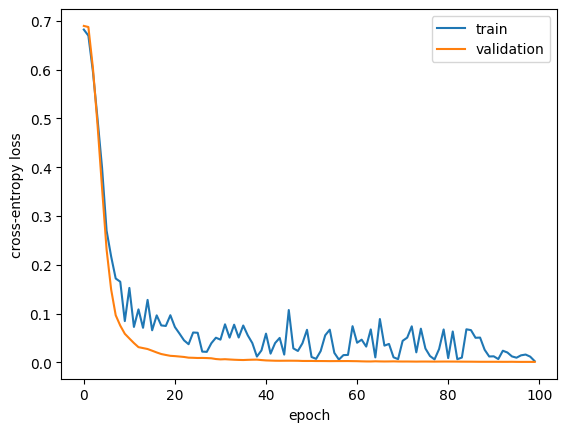

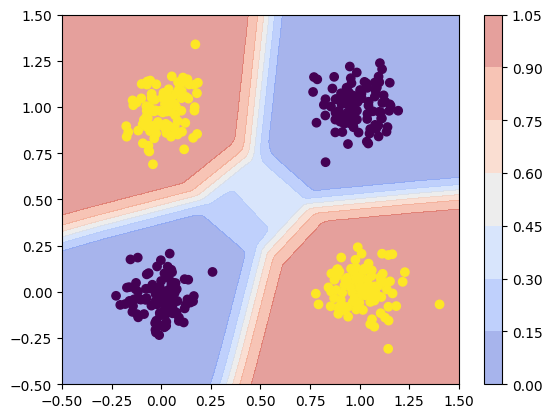

In [68]:
%%time


## second correction: initialization reduces optimization problems
class deepLR_neuralNet(torch.nn.Module):
    
    def __init__(self, input_dim=2, hidden_dim=3, dropout_rate=0.5):
        super().__init__()
        self.layers = self.layers = nn.Sequential(
                        nn.Linear(input_dim, hidden_dim),          # Linear layer
                        nn.ReLU(),                                # ReLU activation
                        nn.Dropout(dropout_rate),                 # Dropout regularization
                        nn.Linear(hidden_dim, 1),                  # Output layer
                        nn.Sigmoid()                              # Sigmoid activation for binary classification
                        )
        
        nn.init.xavier_normal_(self.layers[0].weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.layers[2].weight, gain=nn.init.calculate_gain('sigmoid'))
        
    def forward(self, x):  # Forward pass
        proba = self.layers(x) 
        return proba

model = deepLR_neuralNetWithDropout(input_dim=2, hidden_dim=best_params['hidden_dim'], dropout_rate=best_params['dropout_rate'] ).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), best_params['lr'], best_params['momentum']) 

epochs = 100
train_losses = []
valid_losses = []

print("before training:")
valid(valid_dataloader, model, loss_fn , echo = True)

for t in range(epochs):
    train_losses.append( train(train_dataloader, model, loss_fn, optimizer, echo=False) )
    valid_losses.append( valid(valid_dataloader, model, loss_fn , echo = False) )
print("Done!")
print("after training:")
valid(valid_dataloader, model, loss_fn , echo = True)

plt.plot(train_losses , label = 'train')
plt.plot(valid_losses, label = 'validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')

fig,ax = plt.subplots()

xx, yy = np.meshgrid(np.linspace(-0.5,1.5,100),np.linspace(-0.5,1.5,100))

pred = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)).detach().cpu().numpy()
Z = pred.reshape(xx.shape)


CS = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
cbar = plt.colorbar(CS, ax=ax)

ax.scatter(xor_X[:,0],xor_X[:,1],c=xor_y)

#We can have a look at the latent space represented in the hidden layer.
W_hidden=model.layers[0].weight.detach().cpu().numpy()
b_hidden=model.layers[0].bias.detach().cpu().numpy()

linear_representation = xor_X @ W_hidden.T + \
                            b_hidden
ReLU_representation = [[i[p] if i[p]>0 else 0 for i in linear_representation] for p in range(3)]
